In [1]:
import os
from langchain_google_genai import GoogleGenerativeAIEmbeddings, ChatGoogleGenerativeAI
from langchain.vectorstores import FAISS
from langchain.text_splitter import RecursiveCharacterTextSplitter
from typing import Annotated, TypedDict, List, Dict, Optional
import operator
from langchain.docstore.document import Document
from langchain.prompts import PromptTemplate
from langgraph.graph import END, START, StateGraph
import fitz
from IPython.display import Image, display
from PIL import Image as pilimage, ImageDraw, ImageFont

c:\Users\TharunEllavula\Documents\Git_tutorbot\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Set up Google API Key
GOOGLE_API_KEY = os.getenv("Google_Api_Key")
if not GOOGLE_API_KEY:
    raise ValueError(" Google API Key not found. Please set the environment variable.")
# Initialize LLM
llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash", api_key=GOOGLE_API_KEY)
embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001")

In [3]:
# Define StudyBotState with proper initialization
class StudyBotState(TypedDict):
    pdf_docs: Annotated[list[str], operator.add]
    topic: Optional[str]
    level: Optional[str]
    pdf_text: Annotated[str, operator.add]
    text_chunks: Annotated[list[str], operator.add]
    vector_store: Optional[FAISS]
    study_plan: Optional[str]
    summary: Optional[str]
    quiz: Optional[list[str]]
    flashcards: Optional[str]
    context: Optional[str]

In [4]:
# PDF Text Extraction
def extract_pdf_text(state: StudyBotState) -> dict:
    text = []
    for pdf in state["pdf_docs"]:
        with fitz.open(pdf) as doc:
            for page_num in range(len(doc)):
                extracted_text = doc[page_num].get_text("text")
                text.append(f"\n[{pdf} - Page {page_num + 1}]\n{extracted_text}")
    return {"pdf_text": "\n".join(text).strip()}  

# Split text into chunks
def split_text_into_chunks(state: StudyBotState) -> StudyBotState:
    text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1500,
    chunk_overlap=300,
    separators=["\n\n", "\n", ".", "!", "?", " "])
    
    full_text = state["pdf_text"]
    text_chunks = text_splitter.split_text(full_text)
    return {**state, "text_chunks": text_chunks}

# Create vector store
def create_vector_store(state: StudyBotState) -> StudyBotState:
    docs_with_metadata = []
    for pdf in state["pdf_docs"]:
        with fitz.open(pdf) as doc:
            for page_num in range(len(doc)):
                text = doc[page_num].get_text("text")
                docs_with_metadata.append(Document(
                    page_content=text,
                    metadata={"source": pdf, "page_number": page_num + 1}
                ))
    vector_store = FAISS.from_documents(docs_with_metadata, embedding=embeddings)
    vector_store.save_local("faiss_index")
    return {**state, "vector_store": vector_store}



# Prompts for Study Plan, Summary, Quiz, and Flashcards
study_plan_prompt = PromptTemplate(
    input_variables=["topic", "context", "level"],
    template="""
    Create a {level}-level study plan for {topic} using only the given content:  
    {context}  

    The plan should be simple and well-structured.  
    Include key subtopics, study time estimates,   
    Book names along with page numbers where the topic is explained.  
    Also, add recommended exercises (if available) and important notes to help with learning.  
    """
)

topic_summary_prompt = PromptTemplate(
    input_variables=["topic", "context"],
    template="""
    Summarize {topic} using only the given content:  
    {context}  

    The summary should include:  
    - Introduction 
    - Key Concepts 
    - Challenges 
    - Example Code (if available)  
    - Conclusion  

    Use bullet points for clarity. Keep it simple and to the point.
    """
)

quiz_prompt = PromptTemplate(
    input_variables=["topic", "context", "level"],
    template="""
    Generate a {level}-level multiple-choice quiz on {topic} strictly based on:
    {context}
    Create 10 well-structured questions, each question with 4 answer choices (A, B, C, D),and specify the correct answer with explanation(why that option is correct).
    """
)

flashcards_prompt = PromptTemplate(
    input_variables=["topic", "context"],
    template="""Generate 5 key flashcards for {topic} using this context:\n{context}\nFormat each as:\nQ: ...? | A: ..."""
)

In [5]:
# Asking User for Topic
def ask_user_for_topic(state: StudyBotState) -> dict:
    topic = input("Enter the topic you want to study: ").strip()
    return {"topic": topic}

# Retrie context
def retrieve_context(state: StudyBotState) -> StudyBotState:
    vector_store = FAISS.load_local("faiss_index", embeddings, allow_dangerous_deserialization=True)
    retriever = vector_store.as_retriever(search_kwargs={"k": 5})
    retrieved_docs = retriever.invoke(state["topic"])
    context_text = "\n".join([f"[{doc.metadata['source']} - Page {doc.metadata['page_number']}]\n{doc.page_content}" for doc in retrieved_docs])
    return {"context": context_text}

In [6]:
def generate_output(state, prompt):
    topic = state.get("topic", "unknown topic")
    context = state.get("context", "")
    level = state.get("level", "Beginner")

    if not context:
        return "No context available to generate response."

    formatted_prompt = prompt.format(topic=topic, context=context, level=level)
    response = llm.invoke(formatted_prompt)

    # extracting text from the AI response 
    if hasattr(response, "content"):
        return response.content.strip()
    return "No valid response generated."

In [7]:
# generate study plan
def generate_study_plan(state: StudyBotState) -> StudyBotState:
    study_plan = generate_output(state, study_plan_prompt)
    return {"study_plan": study_plan}

# Generate topic summary
def generate_topic_summary(state: StudyBotState) -> StudyBotState:
    return {"summary": generate_output(state, topic_summary_prompt)}

# Generate quiz
def generate_quiz(state: StudyBotState) -> StudyBotState:
    return {"quiz": generate_output(state, quiz_prompt)}

def generate_flashcards(state: StudyBotState) -> dict:
    prompt = (
        f"Generate exactly 5 well-structured flashcards for {state['topic']} "
        f"using this context:\n{state['context']}\n\n"
        "Each flashcard should follow this format:\n"
        "Front: Question? | Back: Answer."
    )
    flashcards = generate_output(state, prompt)
    # Ensure correct format
    if not isinstance(flashcards, list):
        flashcards = flashcards.split("\n")  # Try to split if it's a string
    # Remove empty or incorrect entries
    valid_flashcards = [card for card in flashcards if " | Back: " in card]
    return {"flashcards": valid_flashcards}

In [11]:
# saving the generated content into Text files.
def save_text(filename, content, folder="study_materials"):
    """Save content to a text file inside the specified folder."""
    if not content:
        print(f":warning: No content to save in {filename}")
        return

    os.makedirs(folder, exist_ok=True)  
    file_path = os.path.join(folder, filename)

    with open(file_path, "w", encoding="utf-8") as file:
        file.write(content.strip())  

    print(f":white_check_mark: File saved: {file_path}")

def save_studyplan(state):
    save_text("study_plan.md", state.get("study_plan", ""))

def save_summary(state):
    save_text("topic_summary.md", state.get("summary", ""))

def save_quiz(state):
    save_text("quiz.md", state.get("quiz", ""))


# Saving Flashcards as images

def save_flashcards_as_images(state):
    flashcards = state.get("flashcards", [])
    if not flashcards:
        print("⚠️ No flashcards to save. Check if flashcards are being generated correctly.")
        return state

    os.makedirs("flashcards_output", exist_ok=True)
    
    try:
        font_path = "/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf"  
        font = ImageFont.truetype(font_path, 24)
    except IOError:
        font = ImageFont.load_default()
    
    img_width, img_height = 800, 400
    margin = 50  # Margin from the left
    text_width = img_width - 2 * margin  # Usable width for text
    
    for idx, card in enumerate(flashcards):
        print(f"Processing flashcard {idx+1}: {card}")
        
        if " | A: " not in card and " | Back: " not in card:
            print(f"⚠️ Skipping malformed flashcard: {card}")
            continue
        
        front, back = card.split(" | A: ", 1) if " | A: " in card else card.split(" | Back: ", 1)
        
        img = pilimage.new("RGB", (img_width, img_height), "white")
        draw = ImageDraw.Draw(img)
        
        def wrap_text(text, font, max_width):
            words = text.split()
            lines = []
            current_line = ""
            for word in words:
                test_line = current_line + (" " if current_line else "") + word
                bbox = draw.textbbox((0, 0), test_line, font=font)
                if bbox[2] - bbox[0] <= max_width:
                    current_line = test_line
                else:
                    lines.append(current_line)
                    current_line = word
            lines.append(current_line)
            return lines
        
        wrapped_q = wrap_text(f"Q: {front}", font, text_width)
        wrapped_a = wrap_text(f"A: {back}", font, text_width)
        
        y = 80
        for line in wrapped_q:
            draw.text((margin, y), line, font=font, fill="black")
            y += draw.textbbox((0, 0), line, font=font)[3] - draw.textbbox((0, 0), line, font=font)[1] + 5
        
        y += 40  # Space between question and answer
        
        for line in wrapped_a:
            draw.text((margin, y), line, font=font, fill="black")
            y += draw.textbbox((0, 0), line, font=font)[3] - draw.textbbox((0, 0), line, font=font)[1] + 5
        
        filename = f"flashcards_output/flashcard_{idx+1}.png"
        img.save(filename)
        print(f"✅ Saved: {filename}")
    
    return state



In [12]:
# Define the workflow
def build_workflow():
    workflow = StateGraph(StudyBotState)
    workflow.add_node("extract_pdf_text", extract_pdf_text)
    workflow.add_node("split_text_into_chunks", split_text_into_chunks)
    workflow.add_node("create_vector_store", create_vector_store)
    workflow.add_node("ask_user_for_topic", ask_user_for_topic)
    workflow.add_node("retrieve_context", retrieve_context)
    workflow.add_node("generate_study_plan", generate_study_plan)
    workflow.add_node("generate_topic_summary", generate_topic_summary)
    workflow.add_node("generate_quiz", generate_quiz)
    workflow.add_node("generate_flashcards", generate_flashcards)
    workflow.add_node("save_study_plan",save_studyplan)
    workflow.add_node("save_topic_summary",save_summary)
    workflow.add_node("save_quiz",save_quiz)
    workflow.add_node("save_flashcards_as_images",save_flashcards_as_images)



    workflow.set_entry_point("extract_pdf_text")
    workflow.add_edge("extract_pdf_text", "split_text_into_chunks")
    workflow.add_edge("split_text_into_chunks", "create_vector_store")
    workflow.add_edge("create_vector_store", "ask_user_for_topic")
    workflow.add_edge("ask_user_for_topic", "retrieve_context")
    workflow.add_edge("retrieve_context", "generate_study_plan")
    workflow.add_edge("retrieve_context", "generate_topic_summary")
    workflow.add_edge("retrieve_context", "generate_quiz")
    workflow.add_edge("retrieve_context", "generate_flashcards")
    workflow.add_edge("generate_topic_summary", "save_topic_summary")
    workflow.add_edge("generate_study_plan", "save_study_plan")
    workflow.add_edge("generate_quiz", "save_quiz")
    workflow.add_edge("generate_flashcards", "save_flashcards_as_images")
    workflow.add_edge("save_study_plan",END)
    workflow.add_edge("save_topic_summary",END)
    workflow.add_edge("save_quiz",END)
    workflow.add_edge("save_flashcards_as_images",END)
    graph = workflow.compile()
    display(Image(graph.get_graph(xray=1).draw_mermaid_png()))
    return graph

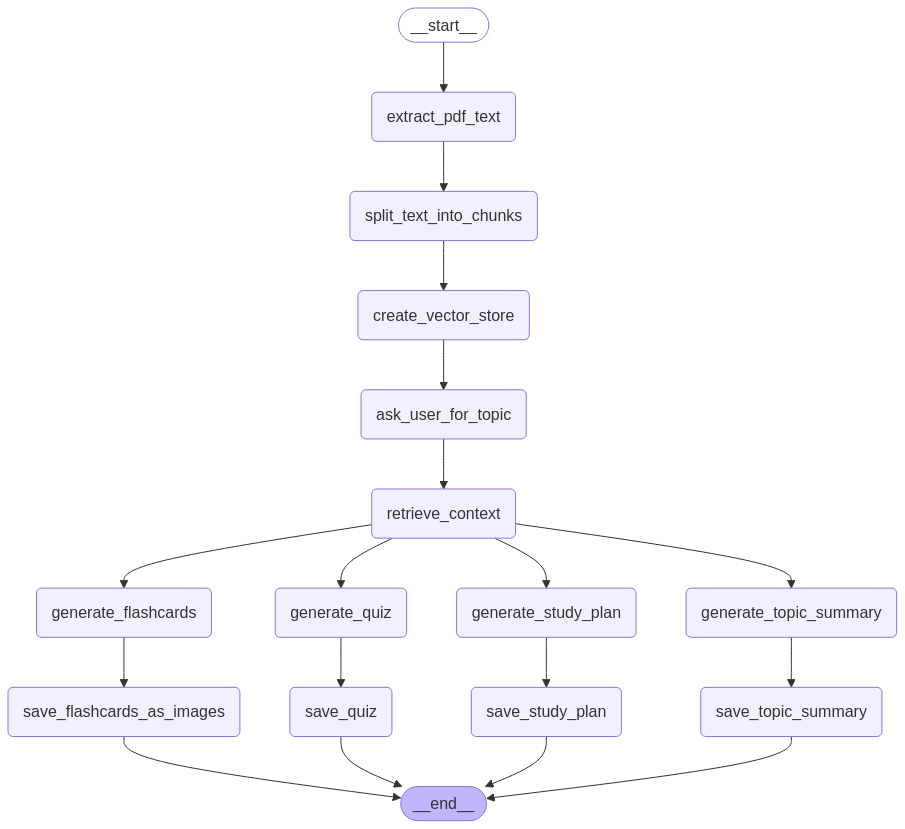

Processing flashcard 1: Front: What are the two main types of functions discussed in the text, and how do they differ? | Back: Fruitful functions return a value, while void functions perform an action but don't return a value (they return `None`).
:white_check_mark: File saved: study_materials\study_plan.md
:white_check_mark: File saved: study_materials\quiz.md
:white_check_mark: File saved: study_materials\topic_summary.md
✅ Saved: flashcards_output/flashcard_1.png
Processing flashcard 2: Front: What is the significance of the `None` value in Python? | Back:  `None` is a special value representing the absence of a return value; it's returned by void functions and has its own type, `NoneType`.
✅ Saved: flashcards_output/flashcard_2.png
Processing flashcard 3: Front:  Describe the "traceback" in the context of Python error handling. | Back: A traceback is a list of functions that were executing when an error occurred, showing the program file, line number, and the function call stack le

In [13]:
if __name__ == "__main__":
    # Initialize the study bot state
    initial_state = StudyBotState(
        pdf_docs=["P1thinkpython2.pdf"],
        topic="functions",  
        level="", 
        pdf_text="", 
        text_chunks=[], 
        vector_store=None, 
        context="", 
        study_plan="", 
        summary="", 
        quiz="", 
        flashcards=[]
    )
    
    # Build and execute workflow
    workflow = build_workflow()
    final_state = workflow.invoke(initial_state)
    
    print(f"📁 Study materials saved: studyplan.txt,topic_summarizer.txt, quiz.txt,Flashcards.txt")
